In [3]:
# Load environment
using Pkg
Pkg.activate("..")

"/Users/domluna/github/NeuralArithmetic/Project.toml"

In [5]:
using NeuralArithmetic
using Flux
using Plots
using DataFrames

In [6]:
N = 1000
hidden_dim = 2

2

In [7]:
struct Dataset
    f
    train
    val # interpolation data
    test # extrapolation data
end

function gen_data_binary(f::F, n::Int, irange=5.0, erange=20.0) where {F}
    X = [randn(n+100)*irange randn(n+100)*irange]'
    y = f.(X[1, :], X[2, :])
    train = (X[:, 1:n], y[1:n])
    val = (X[:, n+1:end], y[n+1:end])
    testX = [randn(100)*erange randn(100)*erange]'
    testy = f.(testX[1, :], testX[2, :])
    test = (testX, testy)
    return Dataset(f, train, val, test)
end

gen_data_binary (generic function with 3 methods)

## Binary Functions

In [8]:
add_data = gen_data_binary(+, N)
sub_data = gen_data_binary(-, N)
div_data = gen_data_binary(/, N)
mul_data = gen_data_binary(*, N)

binary_datasets = Dict(
    "add" => add_data,
    "sub" => sub_data,
    "div" => div_data,
    "mul" => mul_data,
)

Dict{String,Dataset} with 4 entries:
  "add" => Dataset(+, ([-2.69032 2.28769 … -0.300978 -5.39233; 9.5309 3.94196 ……
  "sub" => Dataset(-, ([3.21835 3.1874 … 10.4477 0.355694; 2.96328 9.45753 … 1.…
  "div" => Dataset(/, ([-2.87675 -1.34386 … 1.74469 4.4887; -4.04104 0.828932 ……
  "mul" => Dataset(*, ([3.53495 -12.992 … -1.56364 2.79179; -1.50342 -1.68592 ……

In [9]:
relu6(x) = min.(max.(x, 0.0), 6.0)

linear_model = () -> Chain(Dense(2, hidden_dim), Dense(hidden_dim, 1))
relu6_model = () -> Chain(Dense(2, hidden_dim, relu6), Dense(hidden_dim, 1))
nac_model = () -> Chain(NAC(2, hidden_dim), NAC(hidden_dim, 1))
nalu_model = () -> Chain(NALU(2, hidden_dim), NALU(hidden_dim, 1))

#9 (generic function with 1 method)

In [10]:
loss(m) = (x, y) -> Flux.mse(m(x), y')

function train_model(model, opt, ds::Dataset, epochs::Int, print_interval::Int)
    lossf = loss(model)
    hist = Float64[]
    for i in 1:epochs
        Flux.train!(lossf, [ds.train], opt)
        val_loss = Flux.data(lossf(ds.val...))
        if print_interval != -1 && i % print_interval == 0
            @info "Iteration $i, validation loss = $val_loss"
        end
        push!(hist, val_loss)
    end
    return hist
end

function run_experiment(modelf, datasets::Dict{String, Dataset}, epochs::Int=1000, print_interval::Int=-1)
    df = DataFrame()
    for (name, ds) in datasets    
        m = modelf()
        opt = ADAM(params(m))
        hist = train_model(m, opt, ds, epochs, print_interval)
        df[Symbol(name)] = hist
        @info "Done evaluation dataset $name"
    end
    return df
end

run_experiment (generic function with 3 methods)

Linear model.

┌ Info: Done evaluation dataset add
└ @ Main In[10]:24
┌ Info: Done evaluation dataset sub
└ @ Main In[10]:24
┌ Info: Done evaluation dataset div
└ @ Main In[10]:24
┌ Info: Done evaluation dataset mul
└ @ Main In[10]:24


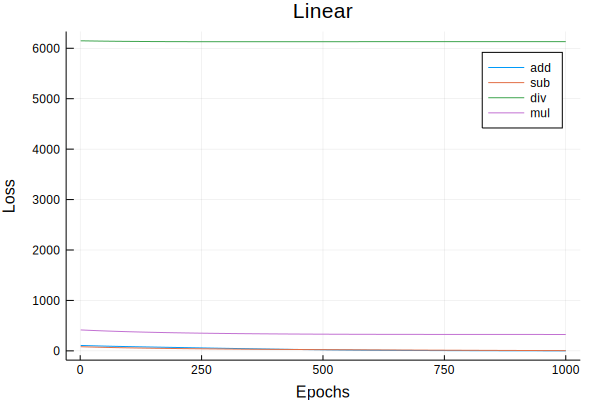

In [11]:
df = run_experiment(linear_model, binary_datasets, 1000);
plot(1:size(df)[1], [df[name] for name in names(df)], 
    title="Linear",
    xlabel="Epochs",
    ylabel="Loss",
    labels=[String.(name) for name in names(df)])

ReLU6 model.

┌ Info: Done evaluation dataset add
└ @ Main In[8]:24
┌ Info: Done evaluation dataset sub
└ @ Main In[8]:24
┌ Info: Done evaluation dataset div
└ @ Main In[8]:24
┌ Info: Done evaluation dataset mul
└ @ Main In[8]:24


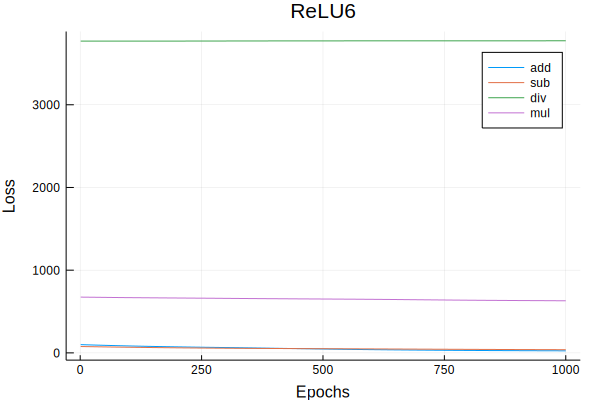

In [11]:
df = run_experiment(relu6_model, binary_datasets, 1000);
plot(1:size(df)[1], [df[name] for name in names(df)], 
    title="ReLU6",
    xlabel="Epochs",
    ylabel="Loss",
    labels=[String.(name) for name in names(df)])

NAC model.

┌ Info: Done evaluation dataset add
└ @ Main In[8]:24
┌ Info: Done evaluation dataset sub
└ @ Main In[8]:24
┌ Info: Done evaluation dataset div
└ @ Main In[8]:24
┌ Info: Done evaluation dataset mul
└ @ Main In[8]:24


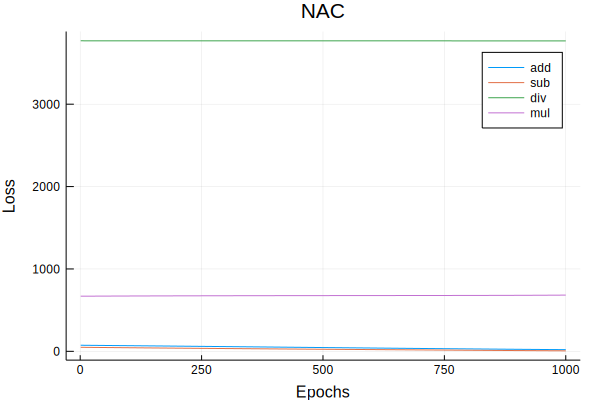

In [12]:
df = run_experiment(nac_model, binary_datasets, 1000);
plot(1:size(df)[1], [df[name] for name in names(df)], 
    title="NAC",
    xlabel="Epochs",
    ylabel="Loss",
    labels=[String.(name) for name in names(df)])

NALU model.

┌ Info: Done evaluation dataset add
└ @ Main In[8]:24
┌ Info: Done evaluation dataset sub
└ @ Main In[8]:24
┌ Info: Done evaluation dataset div
└ @ Main In[8]:24
┌ Info: Done evaluation dataset mul
└ @ Main In[8]:24


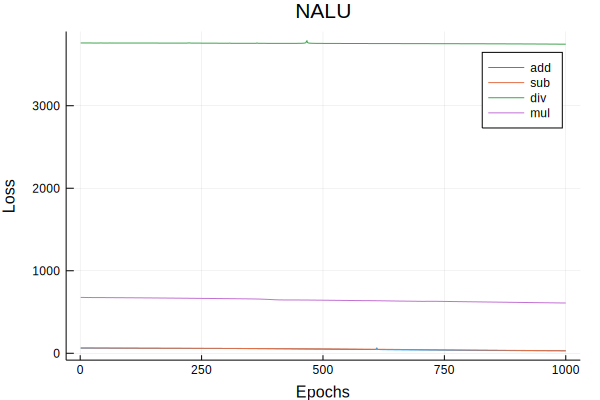

In [14]:
df = run_experiment(nalu_model, binary_datasets, 1000);
plot(1:size(df)[1], [df[name] for name in names(df)], 
    title="NALU",
    xlabel="Epochs",
    ylabel="Loss",
    labels=[String.(name) for name in names(df)])

## Unary Functions

In [ ]:
function gen_data_unary(f::F, n::Int, irange=5.0, erange=20.0) where {F}
    # only positive values
    if F == typeof(sqrt)
        g = rand
    else
        g = randn
    end
    X = g(n+100)*irange
    y = f.(X)
    train = (X[1:n], y[1:n])
    val = (X[n+1:end], y[n+1:end])
    testX = g(100)*erange
    testy = f.(testX)
    test = (testX, testy)
    return Dataset(f, train, val, test)
end

square = (x) -> ^(x, 2)

In [ ]:
sqrt_data = gen_data_unary(sqrt, N)
square_data = gen_data_unary(square, N)

unary_datasets = Dict(
    "sqrt" => sqrt_data,
    "square" => square_data,
)

In [ ]:
df = run_experiment(relu6_model, unary_datasets, 1000);
plot(1:size(df)[1], [df[name] for name in names(df)], 
    title="ReLU6",
    xlabel="Epochs",
    ylabel="Loss",
    labels=[String.(name) for name in names(df)])